In [1]:
import pandas as pd
import sqlite3
import numpy as np

In [62]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

In [2]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot


### Data loading

In [3]:
conn = sqlite3.connect('database.sqlite')

In [4]:
team_query = '''select * from Team''' 
player_query = '''select * from Player'''
player_attributes_query = '''select * from Player_Attributes'''
match_query = '''select * from Match'''
league_query = '''select * from League'''

In [5]:
team = pd.read_sql_query(team_query,conn)
player = pd.read_sql_query(player_query,conn)
player_attributes = pd.read_sql_query(player_attributes_query,conn)
match = pd.read_sql_query(match_query,conn)
league = pd.read_sql_query(league_query,conn)

In [6]:
league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [7]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [8]:
team.head(10)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
5,6,8635,229.0,RSC Anderlecht,AND
6,7,9991,674.0,KAA Gent,GEN
7,8,9998,1747.0,RAEC Mons,MON
8,9,7947,NaN,FCV Dender EH,DEN
9,10,9985,232.0,Standard de Liège,STL


### Data preprocessing

In [9]:
# Populating Team Names

match['home_team'] = match['home_team_api_id'].map(team.set_index('team_api_id')['team_long_name'])
match['away_team'] = match['away_team_api_id'].map(team.set_index('team_api_id')['team_long_name'])
match['league_country'] = match['country_id'].map(league.set_index('country_id')['name'])

In [10]:
status_values = ['win', 'lose', 'draw']

general_values = ['home win', 'away win', 'draw']
general_encoded_values = [0, 1, 2]

home_conditions = [(match['home_team_goal']>match['away_team_goal']), (match['home_team_goal']<match['away_team_goal']), (match['home_team_goal']==match['away_team_goal'])]

away_conditions = [(match['home_team_goal']<match['away_team_goal']), (match['home_team_goal']>match['away_team_goal']), (match['home_team_goal']==match['away_team_goal'])]

In [11]:
match['general_result'] = np.select(home_conditions, general_values)

In [12]:
match['general_encoded_result'] = np.select(home_conditions, general_encoded_values)

In [13]:
match['home_result'] = np.select(home_conditions, status_values)

In [14]:
match['away_result'] = np.select(away_conditions, status_values)

In [15]:
# Selecting main columns:

match = match[['date', 'id', 'league_id', 'country_id', 'league_country', 'season', 'match_api_id', 'home_team_api_id', 'home_team', 'away_team_api_id', 'away_team', 'home_team_goal', 'away_team_goal', 'home_result', 'general_result', 'general_encoded_result', 'away_result', 'B365H', 'B365A', 'B365D']]

In [16]:
match.head(10)

,date,id,league_id,country_id,league_country,season,match_api_id,home_team_api_id,home_team,away_team_api_id,away_team,home_team_goal,away_team_goal,home_result,general_result,general_encoded_result,away_result,B365H,B365A,B365D
0,2008-08-17 00:00:00,1,1,1,Belgium Jupiler League,2008/2009,492473,9987,KRC Genk,9993,Beerschot AC,1,1,draw,draw,2,draw,1.73,5.00,3.40
1,2008-08-16 00:00:00,2,1,1,Belgium Jupiler League,2008/2009,492474,10000,SV Zulte-Waregem,9994,Sporting Lokeren,0,0,draw,draw,2,draw,1.95,3.60,3.20
2,2008-08-16 00:00:00,3,1,1,Belgium Jupiler League,2008/2009,492475,9984,KSV Cercle Brugge,8635,RSC Anderlecht,0,3,lose,away win,1,win,2.38,2.75,3.30
3,2008-08-17 00:00:00,4,1,1,Belgium Jupiler League,2008/2009,492476,9991,KAA Gent,9998,RAEC Mons,5,0,win,home win,0,lose,1.44,7.50,3.75
4,2008-08-16 00:00:00,5,1,1,Belgium Jupiler League,2008/2009,492477,7947,FCV Dender EH,9985,Standard de Liège,1,3,lose,away win,1,win,5.00,1.65,3.50
5,2008-09-24 00:00:00,6,1,1,Belgium Jupiler League,2008/2009,492478,8203,KV Mechelen,8342,Club Brugge KV,1,1,draw,draw,2,draw,4.75,1.67,3.40
6,2008-08-16 00:00:00,7,1,1,Belgium Jupiler League,2008/2009,492479,9999,KSV Roeselare,8571,KV Kortrijk,2,2,draw,draw,2,draw,2.10,3.30,3.20
7,2008-08-16 00:00:00,8,1,1,Belgium Jupiler League,2008/2009,492480,4049,Tubize,9996,Royal Excel Mouscron,1,2,lose,away win,1,win,3.20,2.20,3.40
8,2008-08-16 00:00:00,9,1,1,Belgium Jupiler League,2008/2009,492481,10001,KVC Westerlo,9986,Sporting Charleroi,1,0,win,home win,0,lose,2.25,2.88,3.25
9,2008-11-01 00:00:00,10,1,1,Belgium Jupiler League,2008/2009,492564,8342,Club Brugge KV,8571,KV Kortrijk,4,1,win,home win,0,lose,1.30,9.50,5.25


In [17]:
match.league_country.value_counts()

Spain LIGA BBVA             3040
England Premier League      3040
France Ligue 1              3040
Italy Serie A               3017
Germany 1. Bundesliga       2448
Netherlands Eredivisie      2448
Portugal Liga ZON Sagres    2052
Poland Ekstraklasa          1920
Scotland Premier League     1824
Belgium Jupiler League      1728
Switzerland Super League    1422
Name: league_country, dtype: int64

In [18]:
# Amount of NA's

match.isna().sum()

date                         0
id                           0
league_id                    0
country_id                   0
league_country               0
season                       0
match_api_id                 0
home_team_api_id             0
home_team                    0
away_team_api_id             0
away_team                    0
home_team_goal               0
away_team_goal               0
home_result                  0
general_result               0
general_encoded_result       0
away_result                  0
B365H                     3387
B365A                     3387
B365D                     3387
dtype: int64

In [19]:
# Countries with missing values on Betting columns information --> Remove Poland and Switzerland and fill other countrie's NA's with mean

match[match['B365H'].isna()].league_country.value_counts()

Poland Ekstraklasa          1920
Switzerland Super League    1422
Belgium Jupiler League        22
Portugal Liga ZON Sagres       8
Italy Serie A                  6
France Ligue 1                 4
Netherlands Eredivisie         3
Spain LIGA BBVA                1
Germany 1. Bundesliga          1
Name: league_country, dtype: int64

In [20]:
# Removing Poland and Switzerland

match_final = match.loc[(match['league_country'] != 'Poland Ekstraklasa') & (match['league_country'] != 'Switzerland Super League')]

In [21]:
match_final.groupby('league_country').mean()

,id,league_id,country_id,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,general_encoded_result,B365H,B365A,B365D
league_country,,,,,,,,,,,,
Belgium Jupiler League,864.5,1.0,1.0,1.123332e+06,13810.710648,13810.710648,1.609375,1.192130,0.777199,2.412849,4.310481,3.751553
England Premier League,3248.5,1729.0,1729.0,1.178767e+06,9142.275000,9142.275000,1.550987,1.159539,0.800329,2.701964,4.910437,3.952720
France Ligue 1,6288.5,4769.0,4769.0,1.171642e+06,9808.300000,9808.300000,1.402961,1.040132,0.835526,2.409911,4.389489,3.437790
Germany 1. Bundesliga,9032.5,7809.0,7809.0,1.189377e+06,9180.250000,9180.250000,1.626634,1.274918,0.791667,2.596530,4.375509,3.913788
Italy Serie A,11765.0,10257.0,10257.0,1.236752e+06,10345.651641,10346.633079,1.500829,1.116009,0.797481,2.506616,4.555254,3.599661
Netherlands Eredivisie,14497.5,13274.0,13274.0,1.180382e+06,9181.388889,9181.388889,1.779820,1.301062,0.758987,2.590569,4.916953,4.124834
Portugal Liga ZON Sagres,18667.5,17642.0,17642.0,1.246115e+06,13952.262671,13952.262671,1.408382,1.126218,0.817251,2.938415,4.784946,3.804976
Scotland Premier League,20605.5,19694.0,19694.0,1.204328e+06,9130.754386,9130.599781,1.429276,1.204496,0.828399,2.800493,4.174359,3.821765
Spain LIGA BBVA,23037.5,21518.0,21518.0,1.214688e+06,9032.287500,9032.287500,1.631250,1.135855,0.743092,2.762152,5.226018,4.160408


In [22]:
### Filling NA's with mean -->> See how to automate with a function

match_final.loc[(match_final.league_country == 'Belgium Jupiler League') & (match_final.B365D.isnull()), 'B365D'] = 3.751
match_final.loc[(match_final.league_country == 'Portugal Liga ZON Sagres') & (match_final.B365D.isnull()), 'B365D'] = 3.804
match_final.loc[(match_final.league_country == 'Italy Serie A') & (match_final.B365D.isnull()), 'B365D'] = 3.599
match_final.loc[(match_final.league_country == 'France Ligue 1') & (match_final.B365D.isnull()), 'B365D'] = 3.437
match_final.loc[(match_final.league_country == 'Netherlands Eredivisie') & (match_final.B365D.isnull()), 'B365D'] = 4.124
match_final.loc[(match_final.league_country == 'Spain LIGA BBVA') & (match_final.B365D.isnull()), 'B365D'] = 4.16
match_final.loc[(match_final.league_country == 'Germany 1. Bundesliga') & (match_final.B365D.isnull()), 'B365D'] = 3.913

match_final.loc[(match_final.league_country == 'Belgium Jupiler League') & (match_final.B365A.isnull()), 'B365A'] = 4.310
match_final.loc[(match_final.league_country == 'Portugal Liga ZON Sagres') & (match_final.B365A.isnull()), 'B365A'] = 4.784
match_final.loc[(match_final.league_country == 'Italy Serie A') & (match_final.B365A.isnull()), 'B365A'] = 4.555
match_final.loc[(match_final.league_country == 'France Ligue 1') & (match_final.B365A.isnull()), 'B365A'] = 4.389
match_final.loc[(match_final.league_country == 'Netherlands Eredivisie') & (match_final.B365A.isnull()), 'B365A'] = 4.916
match_final.loc[(match_final.league_country == 'Spain LIGA BBVA') & (match_final.B365A.isnull()), 'B365A'] = 5.22
match_final.loc[(match_final.league_country == 'Germany 1. Bundesliga') & (match_final.B365A.isnull()), 'B365A'] = 4.375

match_final.loc[(match_final.league_country == 'Belgium Jupiler League') & (match_final.B365H.isnull()), 'B365H'] = 2.412
match_final.loc[(match_final.league_country == 'Portugal Liga ZON Sagres') & (match_final.B365H.isnull()), 'B365H'] = 2.938
match_final.loc[(match_final.league_country == 'Italy Serie A') & (match_final.B365H.isnull()), 'B365H'] = 2.506
match_final.loc[(match_final.league_country == 'France Ligue 1') & (match_final.B365H.isnull()), 'B365H'] = 2.409
match_final.loc[(match_final.league_country == 'Netherlands Eredivisie') & (match_final.B365H.isnull()), 'B365H'] = 2.590
match_final.loc[(match_final.league_country == 'Spain LIGA BBVA') & (match_final.B365H.isnull()), 'B365H'] = 2.762
match_final.loc[(match_final.league_country == 'Germany 1. Bundesliga') & (match_final.B365H.isnull()), 'B365H'] = 2.596

C:\Users\tomi_\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
match_final['3+_goals_diff'] = np.where(((match_final['home_team_goal']-match_final['away_team_goal']>2) | (match_final['away_team_goal']-match_final['home_team_goal']>2)), 1, 0)

C:\Users\tomi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
match_final.columns

Index(['date', 'id', 'league_id', 'country_id', 'league_country', 'season',
       'match_api_id', 'home_team_api_id', 'home_team', 'away_team_api_id',
       'away_team', 'home_team_goal', 'away_team_goal', 'home_result',
       'general_result', 'general_encoded_result', 'away_result', 'B365H',
       'B365A', 'B365D', '3+_goals_diff'],
      dtype='object')

### Final Dataset to work with exercises

In [25]:
### Selecting main columns / variables:

match_final = match_final[['date', 'id', 'league_id', 'season', 'home_team_api_id', 'home_team_api_id', 'home_team_goal', 'away_team_goal', 'general_result', 'B365H', 'B365A', 'B365D', '3+_goals_diff']]

# Exercise 1

### Converting dummy variables

In [31]:
## Columns to transform to dummy: season, general_result

match_final_dummies = pd.get_dummies(data=match_final, columns=['season', 'general_result'])

In [32]:
match_final_dummies

,date,id,league_id,home_team_api_id,home_team_api_id,home_team_goal,away_team_goal,B365H,B365A,B365D,...,season_2009/2010,season_2010/2011,season_2011/2012,season_2012/2013,season_2013/2014,season_2014/2015,season_2015/2016,general_result_away win,general_result_draw,general_result_home win
0,2008-08-17 00:00:00,1,1,9987,9987,1,1,1.73,5.00,3.40,...,0,0,0,0,0,0,0,0,1,0
1,2008-08-16 00:00:00,2,1,10000,10000,0,0,1.95,3.60,3.20,...,0,0,0,0,0,0,0,0,1,0
2,2008-08-16 00:00:00,3,1,9984,9984,0,3,2.38,2.75,3.30,...,0,0,0,0,0,0,0,1,0,0
3,2008-08-17 00:00:00,4,1,9991,9991,5,0,1.44,7.50,3.75,...,0,0,0,0,0,0,0,0,0,1
4,2008-08-16 00:00:00,5,1,7947,7947,1,3,5.00,1.65,3.50,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,2015-10-25 00:00:00,24553,21518,9906,9906,2,1,1.57,6.50,3.80,...,0,0,0,0,0,0,1,0,0,1
24553,2015-10-24 00:00:00,24554,21518,9864,9864,2,0,2.25,3.40,3.25,...,0,0,0,0,0,0,1,0,0,1
24554,2015-10-26 00:00:00,24555,21518,8315,8315,3,0,1.53,7.00,4.00,...,0,0,0,0,0,0,1,0,0,1
24555,2015-10-24 00:00:00,24556,21518,7878,7878,1,1,2.30,3.25,3.25,...,0,0,0,0,0,0,1,0,1,0


### Normalizing with Standard Scaler

In [36]:
numeric_columns = ['home_team_goal', 'away_team_goal', 'B365H', 'B365A', 'B365D']

In [38]:
scaler = StandardScaler()

features[numeric_columns] = scaler.fit_transform(features[numeric_columns])

## Exercise 2: Analisis de componentes principales

In [51]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

### Variance analysis

In [46]:
## Analisis inicial de varianzas.

print('Varianza de cada variable')


match_final[numeric_columns].var(axis=0)

Varianza de cada variable


home_team_goal     1.692746
away_team_goal     1.315196
B365H              3.213788
B365A             13.886181
B365D              1.248107
dtype: float64

In [45]:
## Si chequeamos la varianza para las variables standardizadas, entonces la varianza es la misma:

print('Varianza de cada variable')


features[numeric_columns].var(axis=0)

Varianza de cada variable


home_team_goal    1.000044
away_team_goal    1.000044
B365H             1.000044
B365A             1.000044
B365D             1.000044
dtype: float64

### Model training using PCA with scaled features

In [53]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(match_final[numeric_columns])

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [59]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = match_final[numeric_columns].columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)

,home_team_goal,away_team_goal,B365H,B365A,B365D
PC1,0.378624,-0.253670,-0.370864,0.630395,0.507304
PC2,0.017959,0.580720,0.599024,0.148228,0.530698
PC3,-0.730092,-0.544771,0.258417,0.137308,0.290787
PC4,0.568535,-0.549120,0.555228,-0.257368,0.026811
PC5,-0.007423,-0.010382,-0.358570,-0.703945,0.612965


### Heatmap

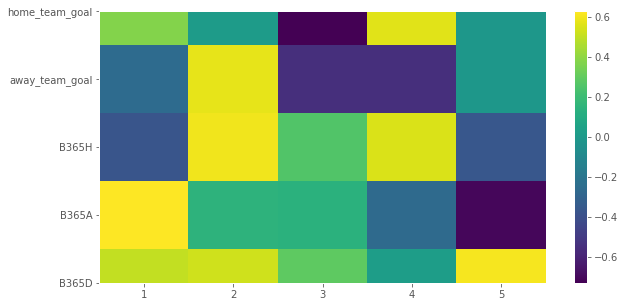

In [64]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(match_final[numeric_columns].columns)), match_final[numeric_columns].columns)
plt.xticks(range(len(match_final[numeric_columns].columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

# EJERCICIO 3


In [ ]:
#normalizamos los datos
scaler=StandardScaler()
df = dataframe.drop(['comprar'], axis=1) # quito la variable dependiente "Y"
scaler.fit(df) # calculo la media para poder hacer la transformacion
X_scaled=scaler.transform(df)# Ahora si, escalo los datos y los normalizo